In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# 1. Inference and Learning

## Question 1: Earthquake Sensors
### Part 1
We know that, per Bayes' Theorem, $p(s_1, s_2|v_1,..,v_N) = \frac{p(v_1,...v_N|s_1,s_2)*p(s_1,s_2)}{p(v_1,...v_N)}$. Given the independence of explosions, we assume a uniform prior for $p(s_1,s_2) = \frac1{S^2}$, and we pull out $p(v_1,..v_N)$ because it does not depend on $s_2$. This gives us $p(s_1, s_2|v_1,..,v_N) = \frac{1}{S^2 * {p(v_1,...v_N)}}*p(v_1,...v_N|s_1,s_2)$, where $\frac{1}{S^2 * {p(v_1,...v_N)}}$ is a constant. Therefore, our posterior $p(s_1|v_1,..,v_N) \propto\sum_{s_2=1}^{S} p(v_1,...v_N|s_1,s_2)$.

Given a Gaussian distribution for our $v_i$ values, per the question, we can define this liklihood as:


$p(v_1,..,v_N|s_1, s_2) = \prod_{i=1}^{N}\frac{1}{\sqrt(2\pi\sigma^2)} * e^-\frac{1}{2\sigma^2}(v_i - (\frac{1}{d^2_i(1) + 0.1} + \frac{1}{d^2_i(2) + 0.1}))^2$.

For numerical stability, we will work in log space, so...

$\log p(v_1,..,v_N|s_1, s_2) = \sum_{i=1}^{N}-\frac{1}{2}*\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}(v_i - (\frac{1}{d^2_i(1) + 0.1} + \frac{1}{d^2_i(2) + 0.1}))^2$.

To save computational resources, note tha the first term, $-\frac{1}{2}*\log(2\pi\sigma^2)$ will be constant for all our calculations. 

Finally, once we have the log liklihoods above, we can marginialize out $s_2$ to get $\log p(s_1|v)$. 

In [2]:
S=2000 # number of points on the spiral - this is discrete # of potential locations for explosions s1 and s2
rate=25 # angular rate of spiral
sd=0.2 # standard deviation of the sensor Gaussian noise
N=30 # number of stations

In [3]:
# define formula for distance to explosion
def sensor_value_1_explosion(x_coord_sensor, y_coord_sensor, x_coord_e, y_coord_e):
    """
    Calculates sensor reading at sensor at (x, y) from (one) explosion at coordinate (ex, ey)
    """
    euclidean_dist = (x_coord_e - x_coord_sensor)**2 + (y_coord_e - y_coord_sensor)**2
    return 1 / (euclidean_dist + 0.1)

In [4]:
# load data (observed vi values for our 30 sensors for 2 potential explosions)
v_obs = (pd.read_csv('/Users/hannahkett/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Graphical Models/Coursework/EarthquakeExerciseData.txt',header=None)).iloc[:,0].to_numpy()

In [5]:
def earthquake_exercise_setup(S, N, rate):
    """
    Setup for explosion detector (using spiral coordinate system)

    # Arguments
        S: number of points on the spiral - this is discrete # of potential locations for explosions s1 and s2
        N: number of feature dimensions
        rate: angular rate of spiral

    # Returns
        v: a S x N matrix of sensor readings, where each
            row contains the readings for a (single) explosion 
            at location S for each sensor
        x_sensor: a vector of length N containing the corresponding
            x-coordinate for each sensor in spiral coordinate space 
        y_sensor: a vector of length N containing the corresponding
            y-coordinate for each sensor in spiral coordinate space 
        x: a vector of length S containing the corresponding
            x-coordinate for each explosion in spiral coordinate space
        y: a vector of length S containing the corresponding
            y-coordinate for each explosion in spiral coordinate space

    """
    # find x and y from spiral coordinates
    x=np.zeros(S)
    y=np.zeros(S)
    for s in range(S):
        theta=rate*2*np.pi*s/S
        r=s/S
        x[s]=r*np.cos(theta)
        y[s]=r*np.sin(theta)

    # define the locations of the detection stations on the surface
    # Also define what value on each sensor would be generated by an explostion at internal location s
    x_sensor=np.zeros(N)
    y_sensor=np.zeros(N)

    # v will hold explosion values for all S locations at N sensors (storing values of 1/di^2(s) + 0.1 for all s, sensor combos)
    v=np.zeros(shape=(S,N))
    for sensor in range(N):
        theta_sensor=2*np.pi*sensor/N
        x_sensor[sensor]=np.cos(theta_sensor)
        y_sensor[sensor]=np.sin(theta_sensor)
        for s in range(S):
            v[s,sensor]=sensor_value_1_explosion(x[s],y[s],x_sensor[sensor],y_sensor[sensor]) # explosion value
    return v, x_sensor, y_sensor, x, y

In [6]:
# get values from setup, this is values for a single explosion
v, x_sensor, y_sensor, x, y = earthquake_exercise_setup(S,N,rate)

In [7]:
def gaussian_log_liklihood(N, sd, x, mu):
    """
    Function to calculate the Gaussian Log Liklhihood for our data (x)
    given a Normal distribution N(mu, sd^2) and sample size N
    """
    constant_log_liklihood_term = -0.5 * np.log(2*np.pi*sd**2)
    return (N * constant_log_liklihood_term) - np.sum((1/(2*sd**2)) * (x - mu)**2,axis=1)

In [8]:
def calculate_posterior_s1(N,S,sd):
    """
    Calculate the posterior Pr(S1|V).

    # Arguments
        S: number of points on the spiral - this is discrete # of potential locations for explosions s1 and s2
        N: number of feature dimensions
        rate: angular rate of spiral

    # Returns
        p_si_v: a vector of size (S, ) containing the posterior distribution P(S1|V)

    """
    # get values from setup
    v, x_sensor, y_sensor, x, y = earthquake_exercise_setup(S,N,rate)

    # to calculate our posterior p(s1 | v1,... vN) (i.e. prob of explosion 1 location given our data) we need to find liklihood
    constant_log_liklihood_term = -0.5 * np.log(2*np.pi*sd**2)

    # define matrix to store log liklihoods
    log_liklihood_matrix = np.zeros(shape = (S,S))

    # our vis are stored in v_obs, to get our sensor readings, use v from the setup function
    # loop through spiral coordinate space
    for s1 in range(S):
        # readings from each of N sensors for first explosion
        explosion_1 = v[s1, :]

        # calculate mu(s1, s2), which is the expected sensor readings for 2 explosions (explosion 1 val + all possible values for explosion 2)
        sensor_readings = explosion_1 + v

        log_p_v_given_s1_s2 = gaussian_log_liklihood(N, sd, v_obs, sensor_readings)
        log_liklihood_matrix[s1, :] = log_p_v_given_s1_s2

    # given log liklihoods p(v1,..vN | s1, s2), need to marginialize out s2 to get posterior p(s1 | v)
    L_max = log_liklihood_matrix.max(axis=1, keepdims=True)
    log_p_s1_given_v = L_max + np.log(np.sum(np.exp(log_liklihood_matrix - L_max), axis=1, keepdims=True))

    # final normalized posterior p(s1|v)
    p_s1_v = np.exp(log_p_s1_given_v).flatten() / np.sum(np.exp(log_p_s1_given_v).flatten())

    return p_s1_v, log_liklihood_matrix

In [9]:
p_s1_v, log_liklihood_matrix = calculate_posterior_s1(N,S,sd)

p_s1_v

array([5.37017594e-108, 6.24905534e-108, 7.55789265e-108, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000], shape=(2000,))

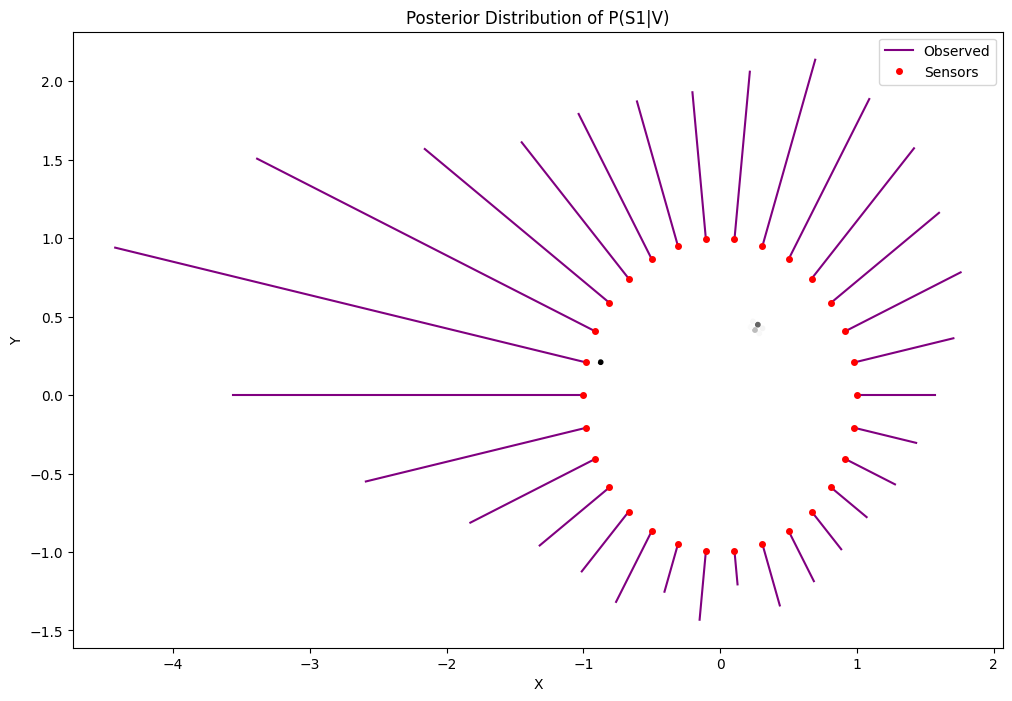

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

# plot observed (noisy) values at each sensor
obs_mean = v_obs.mean()
for i, obs in enumerate(v_obs):
    obs = obs/obs_mean
    theta=np.arctan2(y_sensor[i], x_sensor[i])

    x_coords = (x_sensor[i], x_sensor[i] + obs * np.cos(theta))
    y_coords = (y_sensor[i], y_sensor[i] + obs * np.sin(theta))
    ax.plot(
        x_coords,
        y_coords,
        marker='',
        linestyle='-',
        markersize=4,
        color='purple',
        label='Observed' if i ==0 else None
    )

# plot sensor locations
ax.plot(
    x_sensor,
    y_sensor,
    marker='o',
    linestyle='',
    label='Sensors',
    markersize=4,
    color='red'
)

# plot posterior distribution
post_mean = p_s1_v.mean()
std_posterior_vals = p_s1_v/post_mean

# filter out smallest values
small_vals = std_posterior_vals < 1e-6

ax.scatter(
    x=x[~small_vals],
    y=y[~small_vals],
    c=std_posterior_vals[~small_vals],
    cmap='gray_r',
    s=10
    )

ax.set_title('Posterior Distribution of P(S1|V)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Add a legend
ax.legend()

# Display the plot
plt.show()

### Part 2

The goal for this question is to calculate $\log p(v_1,...v_N|H_2) - \log p(v_1,...v_N|H_1)$, where $H_1$ is the hypothesis that one explosion occured, and $H_2$ is the hypothesis that 2 explosions occurred. 

We know that $p(v_1,...v_N|H_1) = \sum_{s_1=1}^{S}p(v|s_1) * p(s_1)$. Given a uniform prior for $H_1$ that $p(s_1) = \frac{1}{S}$, we can say that $p(v_1,...v_N|H_1) = \frac{1}{S}\sum_{s_1=1}^{S}p(v_1,...v_N|s_1)$. 

In log space,
$\log p(v_1,...v_N|H_1) = -\log S + \log (\sum_{s_1=1}^{S}p(v_1,...v_N|s_1))$. 


For $H_2$, we know that $p(v_1,...v_N|H_2) = \sum_{s_1=1}^{S}\sum_{s_2=1}^{S}p(v|s_1) * p(s_1, s_2)$. Given a uniform prior for $H_2$ that $p(s_1,s_2) = \frac{1}{S^2}$, we can say that $p(v_1,...v_N|H_2) = \frac{1}{S^2}\sum_{s_1=1}^{S}\sum_{s_2=1}^{S}p(v_1,...v_N|s_1, s_2)$. 

In log space,
$\log p(v_1,...v_N|H_2) = -\log S^2 + \log (\sum_{s_1=1}^{S}\sum_{s_2=1}^{S}p(v_1,...v_N|s_1,s_2))$. 



In [11]:
def calculate_log_bayes(N,sd,v_obs,v):
    """
    Calculate the log Bayes factor for H1 and H2
    # Arguments
        N: number of feature dimensions
        sd: the standard deviation of the sensor Gaussian noise
        v_obs: a vector of shape (N,) of observed (noisy) sensor readings
        v: a matrix of shape (2000, 30) containing sensor readings at each spiral point

    # Returns
        log_bayes: a float value of log p(v|H2) - log p(v|H1), or the log Bayes factor
    """

    # calculations for H1
    log_p_v_s1_H1 = gaussian_log_liklihood(N, sd, v_obs, v)
    log_sum_liklihood_h1 = log_p_v_s1_H1.max() + np.log(np.sum(np.exp(log_p_v_s1_H1 - log_p_v_s1_H1.max())))
    log_p_v_H1 = -np.log(S) + log_sum_liklihood_h1

    # calculations for H2
    # use log_liklihood_matrix from part 1, which contains S x S combinations of sensor readings for explosions s1, s2
    log_sum_liklihood_h2 = log_liklihood_matrix.max() + np.log(np.sum(np.exp(log_liklihood_matrix - log_liklihood_matrix.max())))
    log_p_v_H2 = -np.log(S**2) + log_sum_liklihood_h2

    # final calculation log p(v|H2) - log p(v|H1)
    log_bayes = log_p_v_H2 - log_p_v_H1

    return log_bayes

In [12]:
log_p_v_H2_minus_log_p_v_H1 = calculate_log_bayes(N,sd,v_obs,v)
print('Log Bayes Factor', log_p_v_H2_minus_log_p_v_H1)

Log Bayes Factor 735.6803747602522


### Part 3
Because the $\log p(v|H_2) - \log p(v|H_1)$, or the log Bayes Factor, is greater than 0 (and very large), it provides strong evidence in favor of $H_2$ over $H_1$. This makes sense, because the log odds for a probability distribution is $\log\frac{p(X=1)}{p(X=0)}$, which in the case of these two hypotheses (mutually exclusive), would be $\log\frac{p(H_2=True|v)}{p(H_1=True|v)}$. This is the odds that there are 2 explosions vs. 1. We can replace $p(H_2=True|v)$ with $p(v|H2)*p(H_2)$ and $p(H_1=True|v)$ with $p(v|H1)*p(H_1)$ due to Bayes Rule. Because in this case, we assume that $p(H_1) = p(H_2)$, this can be expressed as $\log \frac{p(v|H_2)}{p(v|H_1)}$, which is equivalent to $\log p(v|H_2) - \log p(v|H_1)$.

### Part 4
If there were K explosions, it would be very computationally complex to calculate $\log p(v|H_K)$. Starting with $H_2$ as an example, to calculate $\log p(v|H_2)$, we have to compute the log liklihoods $p(v_1,...v_N | s1, s2)$. To do this, we have to consider N sensors and loop through S twice, once for each explosion. This makes $O(S * S * N)$ the computational complexity of calculating $\log p(v|H_2)$. In the case of K explosions, we would have to loop through S K times for each sensor N, which would result in a computational complexity of $O(S^K * N)$. This complexity will quickly explode for higher dimensions K. 

## Question 2: Meeting Scheduling

### Part (a)
For N friends, we are given the following probabilities of i-th friend being delayed $P(D_i)$:
- $P(D_i≤0 min) = 0.7$
- $P(0 < D_i < 5 min) = 0.1$
- $P(5 mins ≤ D_i < 10 min) = 0.1$
- $P(10 min ≤ D_i < 15 min) = 0.07$
- $P(15 min ≤ D_i < 20 min) = 0.02$
- $P(20 min ≤ D_i) = 0.01$

If we define $T$ to be the desired meeting time, the goal of this question is to maximize $T$, while maintaining P(make train) ≥ 0. The friends will only make the train if none of them have a delay > 21:05 - T. In other words, to make the train, $D_{max} ≤ 21:05 - T$.

Because the delays of the N friends are i.i.d., setting $d= 21:05 - T$, we can write the probability that none of the friends are delayed as $P($ make train $) = \prod_{i=1}^N P(D_i ≤ d)$. 

For each individual friend, we can calculate the CDF for each friend ($P(D_i ≤ d)$) using the discrete probability distribution for each value of d. Given the independence assumptions for each friend's delay, we can simply raise these CDFs to the power of N. We will then solve for when this is >= 0.9, to find the latest possible meeting time that ensures 0.9 probability of catching a train. 


In [13]:
def get_arrival_time(n, make_train_prob, P_Di_d, delays, train_time):
    """
    Function to calculate the latest meeting time for N friends
    to ensure the probability of making the train is at least X%.

    # Arguments
        n: the number of friends
        make_train_prob: the minimum desired probability of making the train 
        P_Di_d: a tuple containing the CDF of P(Di <= d) for the ith friend
        delays: a list of values of d (the # of minutes delayed)
        train_time: a string of format HH:MM of the scheduled train time

    # Returns
        meeting_time: a datetime object of optimal meeting time
        delay: the maximum number of minutes delayed
    """

    P_D1_N_d = np.array([p**n for p in P_Di_d])
    min_prob = (min(P_D1_N_d[P_D1_N_d >= make_train_prob]))
    min_index = 6 - len(P_D1_N_d[P_D1_N_d >= make_train_prob])

    delay =  delays[min_index]
    meeting_time = (pd.Timestamp(train_time) - pd.Timedelta(delay,unit='m')).time()

    return (meeting_time, delay)

In [14]:
# Initial setup for CDF F(d), representing P(Di <= d) for i-th friend
P_Di_0 = round(0.7,2)
P_Di_5 = round(P_Di_0 + 0.1,2)
P_Di_10 = round(P_Di_5 + 0.1,2)
P_Di_15 = round(P_Di_10 + 0.07,2)
P_Di_20 = round(P_Di_15 + 0.02,2)
P_Di_20_plus = round(P_Di_20 + 0.01,2)

# delays in min, use 50 for >25
delays = [0,5,10,15,20,50]

P_Di_d = (P_Di_0, P_Di_5, P_Di_10, P_Di_15, P_Di_20, P_Di_20_plus)

# for N friends, find P(D1 <= d, D2 <= d, D3 <= d, ... DN <=d) = P(D1 <= d) * P(D2 <= d) ... * P(DN <=d)
N = [3, 5, 10]
meeting_times = {}
train_time = '21:05'
make_train_prob = 0.9
for n in N:
    meeting_time, delay = get_arrival_time(n, make_train_prob, P_Di_d, delays, train_time)

    print(f'With {n} friends, in order to ensure at least a {round(make_train_prob*100)}% prob. of catching a train, need to be {delay} minutes early.')
    print('Tell friends to arrive at:', meeting_time, '\n')

    meeting_times[n] = [meeting_time, delay]

With 3 friends, in order to ensure at least a 90% prob. of catching a train, need to be 15 minutes early.
Tell friends to arrive at: 20:50:00 

With 5 friends, in order to ensure at least a 90% prob. of catching a train, need to be 20 minutes early.
Tell friends to arrive at: 20:45:00 

With 10 friends, in order to ensure at least a 90% prob. of catching a train, need to be 20 minutes early.
Tell friends to arrive at: 20:45:00 



| Number of Friends (N)    | Time to Arrive |
| -------- | ------- |
| 3  | 20:50 |
| 5 | 20:45 |
| 10    | 20:45 |



### Part (b)

With different distributions for $P(D_i≤d)$ for Punctual and Non-Punctual friends, we no longer have can just raise the CDF for an individual friend's delay to the power of N. Instead, we have to use a Binomial distribution to model P(make train) = P(make train | P(X=k)) * P(X=k), where k is the number of punctual friends, and use that to weight the CDFs:

$\sum_{k=0}^N[\binom{N}{k}* (\frac{2}{3})^k * (\frac{1}{3})^{N-k} * F_{punctual}(d)^k * F_{nonpunctual}(d)^{N-k}]$

In [15]:
def binomial_pdf(n,k,p, p_success_1, p_success_2):
    return comb(n, k) * p**k * (p_success_1)**k * (1 - p)**(n-k) * (p_success_2)**(n-k)

In [16]:
# Find CDF Fp(d), representing P(Di <= d) for i-th friend, given that the friend is PUNCTUAL
P_Di_0 = round(0.7,2)
P_Di_5 = round(P_Di_0 + 0.1,2)
P_Di_10 = round(P_Di_5 + 0.1,2)
P_Di_15 = round(P_Di_10 + 0.07,2)
P_Di_20 = round(P_Di_15 + 0.02,2)
P_Di_20_plus = round(P_Di_20 + 0.01,2)

# Find CDF Fnp(d), representing P(Di <= d) for i-th friend, given that the friend is NOT PUNCTUAL
P_Di_0_np = round(0.5,2)
P_Di_5_np = round(P_Di_0_np + 0.2,2)
P_Di_10_np = round(P_Di_5_np + 0.1,2)
P_Di_15_np = round(P_Di_10_np + 0.1,2)
P_Di_20_np = round(P_Di_15_np + 0.05,2)
P_Di_20_plus_np = round(P_Di_20_np + 0.05,2)

P_Di_d_p = (P_Di_0, P_Di_5, P_Di_10, P_Di_15, P_Di_20, P_Di_20_plus)
P_Di_d_np = (P_Di_0_np, P_Di_5_np, P_Di_10_np, P_Di_15_np, P_Di_20_np, P_Di_20_plus_np)

# for N friends, find P(D1 <= d, D2 <= d, D3 <= d, ... DN <=d) = P(D1 <= d) * P(D2 <= d) ... * P(DN <=d)
# p(Punctual) = 2/3
p_punctual = 2/3

for n in N:
    meeting_time = meeting_times[n]

    punctual_prob = P_Di_d_p[delays.index(meeting_time[1])]
    non_punctual_prob = P_Di_d_np[delays.index(meeting_time[1])]

    # calculate probabilities of missing train for each combination
    prob_make_train = 0
    for k in range(n+1):
        prob_make_train += binomial_pdf(n,k,p_punctual, punctual_prob, non_punctual_prob)
    
    print(f'With {n} friends and chosen meeting time of {meeting_times[n][0]}, having separate distributions for punctual and non-punctual friends\n results in a probability of missing the train is: {round(1-prob_make_train,4)}')

With 3 friends and chosen meeting time of 20:50:00, having separate distributions for punctual and non-punctual friends
 results in a probability of missing the train is: 0.1516
With 5 friends and chosen meeting time of 20:45:00, having separate distributions for punctual and non-punctual friends
 results in a probability of missing the train is: 0.1113
With 10 friends and chosen meeting time of 20:45:00, having separate distributions for punctual and non-punctual friends
 results in a probability of missing the train is: 0.2103


| Number of Friends (N)    | Probability of Missing Train |
| -------- | ------- |
| 3  | 0.1516 |
| 5 | 0.1113 |
| 10    | 0.2103 |



### Bonus

The goal is to find the posterior distribution for the count of non-punctual friends, given that N=5, that the meeting time was 20:45, and that the train was missed. This means that the delay of at least one of the N = 5 friends was > 20 minutes, or equivalently the complement of the probability that all friends saw a delay of ≤ 20. 

Let X be the count of non-punctual friends. Bayes' Theorem tells us that our posterior $P(X|D_{max} > 20) = \frac{P(D_{max}>20|X)*P(X)}{P(D_{max}>20)}$. As we saw in the previous question, we can use a Binomial distribution to model the number of non-punctual friends, with N=5, k=the number of non-punctual friends, and $P(np)=\frac13$.

$P(D_{max}>20|X=k) = 1-(F_{nonpunctual}(20)^k * F_{punctual}(20)^{5-k})$

$P(X=k) = \binom{5}{k}* (\frac{1}{3})^k * (\frac{2}{3})^{5-k} $

Per, our answer in Part (b) (swapping k to represent # of non-punctual friends for consistency), $P(D_{max}>20)$ is the probability of missing the train, so we can use our the same formula in Part (b) that $P(D_{max}>20)= \sum_{k=0}^5[\binom{5}{k}* (\frac{1}{3})^k * (\frac{2}{3})^{5-k} * (1-F_{nonpunctual}(d)^k * F_{punctual}(d)^{5-k})] =0.1113$.

Therefore, we can calculate our posterior $P(X|D_{max} > 20) = \frac{\binom{5}{k}* (\frac{1}{3})^k * (\frac{2}{3})^{5-k} (1-F_{nonpunctual}(20)^k * F_{punctual}(20)^{5-k})}{0.1113}$.

In [17]:
n = 5
p_nonpunctual = 1-p_punctual

def prior_X(n, k, p):
    return comb(n, k) * p**k * (1 - p)**(n-k)

def liklihood_20_plus(n, k, p1, p2):
    return 1- ((p1)**k * (p2)**(n-k))


posterior_p_x_missed = []
for k in range(5+1):
    punctual_prob = P_Di_d_p[delays.index(20)]
    non_punctual_prob = P_Di_d_np[delays.index(20)]

    prior = prior_X(n, k, p=1/3)
    liklihood = liklihood_20_plus(n, k, p1=non_punctual_prob, p2=punctual_prob)
    posterior_p_x_missed.append((prior*liklihood)/0.1113)

posterior_p_x_missed

[np.float64(0.05798728839491397),
 np.float64(0.25862342314361925),
 np.float64(0.36768649591989916),
 np.float64(0.23617148994856912),
 np.float64(0.07159636488340199),
 np.float64(0.008364264546567138)]

| Number of Non-Punctual Friends Friends (X)    | Posterior Probability P(X=k\|Missed Train)|
| -------- | ------- |
| 0        | 0.0580 |
| 1        | 0.2586 |
| 2        | 0.3677 |
| 3        | 0.2362 |
| 4        | 0.0716 |
| 5        | 0.0084 |



## Question 3: Three Weather Stations